In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import MeanIoU



In [2]:
def load_data(image_dir, mask_dir, img_size=(256, 256)):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = load_img(img_path, target_size=img_size, color_mode="grayscale")
        img = img_to_array(img) / 255.0
        images.append(img)

        mask = load_img(mask_path, target_size=img_size, color_mode="grayscale")
        mask = img_to_array(mask) / 255.0
        masks.append(mask)

    return np.array(images), np.array(masks)

image_dir = '/content/drive/MyDrive/NCA/DATABASES/Shenzhen_datase-20240711T162426Z-001/Shenzhen_datase/img'
mask_dir = '/content/drive/MyDrive/NCA/DATABASES/Shenzhen_datase-20240711T162426Z-001/Shenzhen_datase/mask'
img_size = (256, 256)

images, masks = load_data(image_dir, mask_dir, img_size)


In [3]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [4]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [5]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    iou = (intersection + smooth) / (sum_ - intersection + smooth)
    return iou

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return K.mean(f1)


In [6]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coef, iou_coef, f1_score, MeanIoU(num_classes=2)])


In [7]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=8)


Epoch 1/50
57/57 [==============================] - 85s 885ms/step - loss: 3.1417 - accuracy: 0.7406 - dice_coef: 0.3308 - iou_coef: 0.7807 - f1_score: 0.0134 - mean_io_u: 0.3734 - val_loss: 0.3370 - val_accuracy: 0.8381 - val_dice_coef: 0.4933 - val_iou_coef: 0.8796 - val_f1_score: 0.1701 - val_mean_io_u: 0.3768
Epoch 2/50
57/57 [==============================] - 29s 507ms/step - loss: 0.2491 - accuracy: 0.9047 - dice_coef: 0.6674 - iou_coef: 0.9064 - f1_score: 0.2831 - mean_io_u: 0.3734 - val_loss: 0.1326 - val_accuracy: 0.9485 - val_dice_coef: 0.8480 - val_iou_coef: 0.9525 - val_f1_score: 0.3230 - val_mean_io_u: 0.3768
Epoch 3/50
57/57 [==============================] - 28s 493ms/step - loss: 0.1209 - accuracy: 0.9536 - dice_coef: 0.8629 - iou_coef: 0.9566 - f1_score: 0.3450 - mean_io_u: 0.3734 - val_loss: 0.0937 - val_accuracy: 0.9638 - val_dice_coef: 0.8885 - val_iou_coef: 0.9663 - val_f1_score: 0.3491 - val_mean_io_u: 0.3768
Epoch 4/50
57/57 [==============================] - 28s

4/4 [==============================] - 14s 5s/step


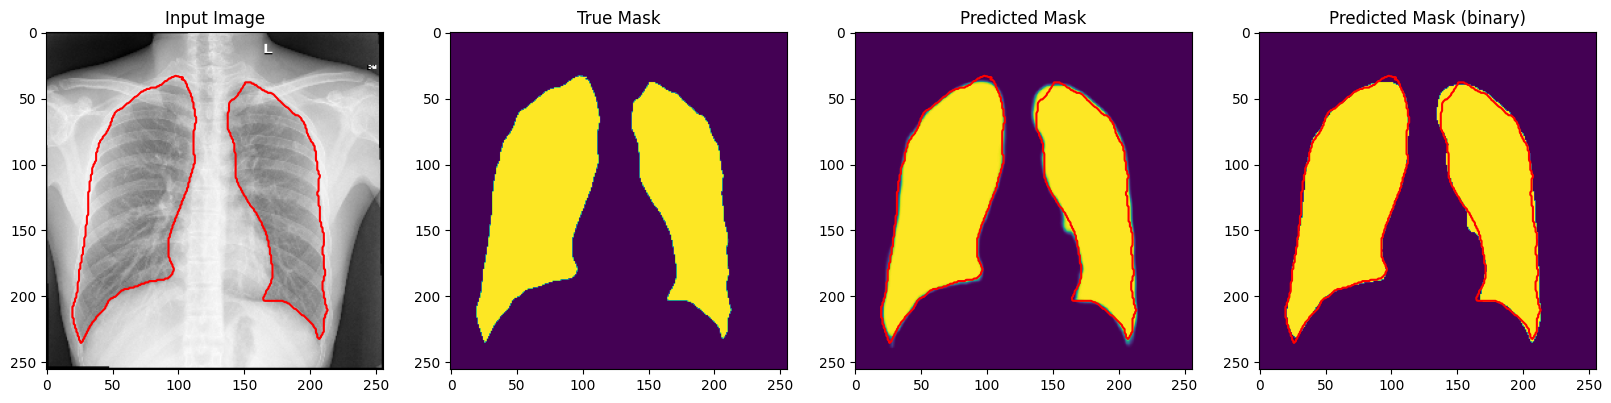

In [8]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = np.random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='gray')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[0].set_title('Input Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('True Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[2].set_title('Predicted Mask')

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='r', levels=[0.5])
    ax[3].set_title('Predicted Mask (binary)')

# Prever em imagens de validação
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)

# Binarizar as previsões
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

# Plotar amostras
plot_sample(X_val, y_val, preds_val, preds_val_t)


In [9]:
results = model.evaluate(X_val, y_val)
print("Validation Loss, Accuracy, Dice Coefficient, IoU, F1 Score, Mean IoU:", results)


4/4 [==============================] - 2s 421ms/step - loss: 0.1195 - accuracy: 0.9767 - dice_coef: 0.9486 - iou_coef: 0.9864 - f1_score: 0.4415 - mean_io_u: 0.7673
Validation Loss, Accuracy, Dice Coefficient, IoU, F1 Score, Mean IoU: [0.11950773745775223, 0.9766843318939209, 0.9486389756202698, 0.9864177107810974, 0.4414651095867157, 0.7672691345214844]


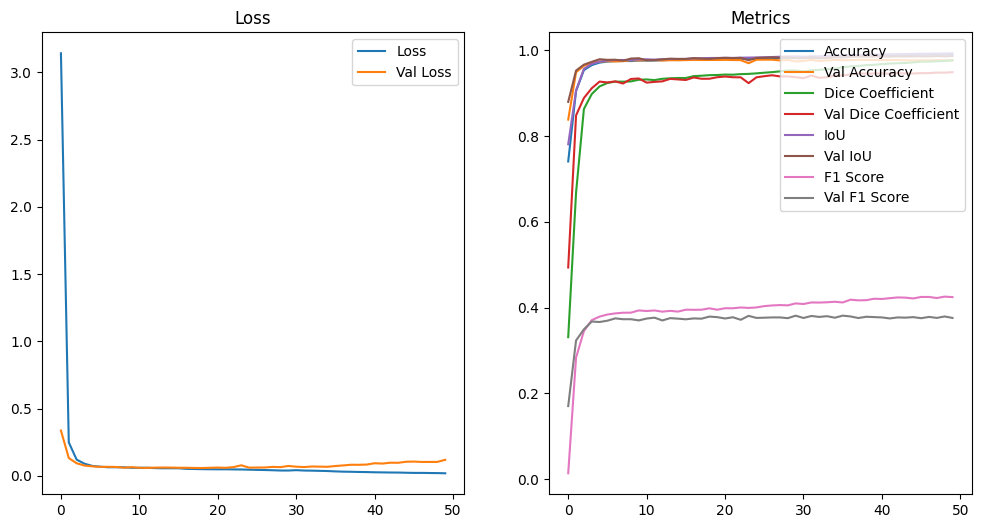

In [10]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['dice_coef'], label='Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Val Dice Coefficient')
plt.plot(history.history['iou_coef'], label='IoU')
plt.plot(history.history['val_iou_coef'], label='Val IoU')
plt.plot(history.history['f1_score'], label='F1 Score')
plt.plot(history.history['val_f1_score'], label='Val F1 Score')
plt.legend(loc='upper right')
plt.title('Metrics')
plt.show()
#callback checkpoint, loss de validação

In [11]:
model.save('/content/drive/MyDrive/NCA/DATABASES/Shenzhen_datase-20240711T162426Z-001/MODELOS')